In [ ]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse, stochastic_wmmse
from src.sc import SyntheticControl
from src.experiment import ExperimentInterferenceModelComparison

%reload_ext autoreload
%autoreload 2
%aimport src

In [68]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [69]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-121.454722,-108.554816
1,-116.053588,-102.024682
2,-119.517242,-105.336481
3,-133.663371,-113.985790
4,-116.439116,-108.858838
5,-123.386710,-103.183378
6,-127.666410,-103.612398
7,-109.589102,-114.303190
8,-118.376806,-106.366837
9,-124.628691,-118.578841


In [70]:
simulator = NetworkSimulator(Tx_radius=200, Rx_radius=25, num_Tx_netA=5, num_Rx_per_Tx_netA=10, num_Tx_netB=3, num_Rx_per_Tx_netB=10)


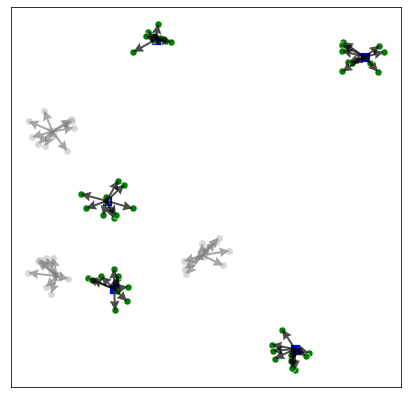

In [71]:
simulator.plot_network()

In [72]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-101.305109,-105.494718,-92.657587,-90.301627,-82.257068,-89.648809,-95.877388,-107.570325,-96.970589,-84.512606,...,-139.986361,-150.240442,-151.803836,-146.561966,-147.170044,-150.906409,-151.374481,-152.649290,-154.401120,-158.604436
1,-169.927455,-175.005054,-168.276528,-164.476008,-170.066703,-167.777549,-171.017157,-164.827352,-156.006865,-169.281146,...,-161.035161,-165.100285,-174.052351,-175.630807,-183.355892,-163.954959,-174.007518,-162.747007,-170.225129,-165.528628
2,-138.522802,-130.991605,-128.562095,-147.304053,-138.603758,-141.705636,-127.877090,-138.154731,-127.338348,-136.049156,...,-107.716489,-112.630247,-107.662819,-94.467519,-102.327204,-97.428649,-114.946778,-106.071131,-114.885996,-106.945550
3,-159.336975,-173.862292,-172.988857,-168.765706,-175.198012,-176.030136,-167.344955,-174.035012,-172.142309,-165.828905,...,-156.499194,-155.105861,-160.856842,-159.160802,-158.537880,-163.941077,-150.084392,-155.447536,-157.505221,-151.634951
4,-161.689096,-156.876685,-141.076556,-149.691627,-147.565733,-153.622955,-125.408869,-154.187354,-149.518243,-141.770633,...,-122.440881,-117.453098,-108.488085,-126.257135,-109.645907,-104.049084,-113.901738,-110.695715,-109.928610,-108.766274
5,-125.979803,-130.800917,-117.365490,-133.228131,-125.718420,-104.636769,-115.599850,-128.272759,-125.906418,-135.458513,...,-129.048356,-104.138308,-114.366187,-132.500083,-128.860461,-124.564360,-138.517645,-126.468078,-129.575944,-126.288583
6,-169.209355,-158.760964,-159.444653,-176.898773,-166.289402,-167.763566,-156.856752,-159.001897,-156.486095,-156.698229,...,-128.939138,-149.369243,-132.945192,-131.418785,-145.579342,-141.029140,-127.782008,-138.078873,-124.421419,-130.041879
7,-141.351599,-153.555692,-159.593200,-147.874053,-137.645097,-152.338464,-142.588224,-141.862431,-137.308573,-161.153748,...,-99.448204,-101.804119,-80.459363,-80.098996,-93.433651,-99.749801,-92.663271,-106.295020,-92.682278,-91.522308


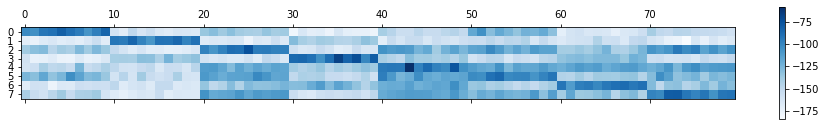

In [73]:
simulator.plot_gain_mat()

## Model Comparisons

In [74]:
simulator.weighted_sum_rate_Gnats([200 for i in range(simulator.num_Rx)], Rx_weights=np.ones(simulator.num_Rx), part='A')

737.908337706554

In [75]:
# model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
# model_comparison.data_generation(num_samples=100, max_power=500, netB_power_mode='zero')
# model_comparison.modeling()

In [76]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='zero')

In [77]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='dependent')

In [78]:
# model_comparison.run(num_rounds=100, netA_power_mode='wmmse', netB_power_mode='uniform')

## Algorithm Comparisons

In [79]:
max_power = 200
netB_power_training_mode = 'dependent' # ['dependent', 'zero', 'random']
netB_power_testing_mode = 'dependent' # ['dependent', 'zero', 'random', 'uniform']

max_iterations = 300

model_comparison = ExperimentInterferenceModelComparison(simulator=simulator)
model_comparison.data_generation(num_samples=1000, max_power=max_power, netB_power_mode=netB_power_training_mode)
model_comparison.modeling(synthetic_constrained=True)
starting_powers_mW = [1e-5 for i in range(simulator.num_Rx)]
# Rx_weights = np.random.uniform(0.1, 1, simulator.num_Rx)
Rx_weights = np.ones(simulator.num_Rx)

In [80]:
rates_original_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='original',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

In [81]:
rates_local_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='local',
    interference_models=[],
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

In [82]:
rates_sc_method = stochastic_wmmse(
    simulator=simulator,
    Rx_powers_mW=starting_powers_mW,
    Rx_max_powers_mW=max_power,
    Rx_weights=Rx_weights,
    interference_mode='sc_estimate',
    interference_models=model_comparison.sc_models,
    netB_power_mode = netB_power_testing_mode,
    power_corr_mat=model_comparison.power_corr_mat,
    max_iter=max_iterations,
);

In [83]:
# rates_lr_method = stochastic_wmmse(
#     simulator=simulator,
#     Rx_powers_mW=starting_powers_mW,
#     Rx_max_powers_mW=max_power,
#     Rx_weights=Rx_weights,
#     interference_mode='lr_estimate',
#     interference_models=model_comparison.lr_models,
#     netB_power_mode = netB_power_testing_mode,
#     power_corr_mat=model_comparison.power_corr_mat,
#     max_iter=max_iterations,
# );

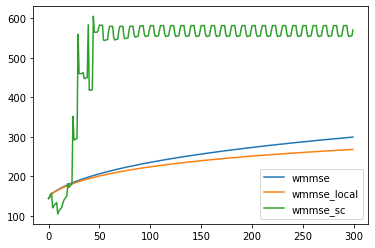

In [84]:
data = pd.DataFrame({
    'wmmse': rates_original_method,
    'wmmse_local': rates_local_method,
    'wmmse_sc': rates_sc_method,
    # 'wmmse_lr': rates_lr_method,
})
data.plot();

In [ ]:
from IPython.display import clear_output

for i in range(10):
    clear_output(wait=True)
    print("Hello World!")